In [2]:
%load_ext rpy2.ipython
%load_ext autoreload
%autoreload 2

%matplotlib inline  
from matplotlib import rcParams
rcParams['figure.figsize'] = (16, 100)

import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore") # Ignore all warnings
# warnings.filterwarnings("ignore", category=RRuntimeWarning) # Show some warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from IPython.display import display, HTML

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [40]:
%%R
library(mgcv)
library(DHARMa)
library(dplyr)
library(ggplot2)
library(ggfortify)
library(gamlss)
library(readr)
library(pROC)
library(caret)


Loading required package: lattice

Attaching package: ‘caret’

The following object is masked from ‘package:gamlss’:

    calibration



# Linear Regression :

- Dependent Variable : `score`
- Independent Variables : 
    - `total_population`, 
    - `median_household_income`, 
    - `black_perct`, 
    - `asian_perct`, 
    - `no_coll_perct`, 
    - `poverty_rate` 

In [17]:
%%R

rest_model_balanced <- read_csv("Data/rest_model_balanced.csv")
rest_model_balanced$score <- as.numeric(rest_model_balanced$score)

# Select features
features <- c('total_population', 'median_household_income', 'black_perct', 'asian_perct', 'no_coll_perct', 'poverty_rate')

# Add a constant column for the intercept (if needed, R automatically includes it in lm)
# For demonstration, adding intercept is not needed as lm() does it automatically

# Define the model formula
formula <- paste("score ~", paste(features, collapse = " + "))

# Fit the linear regression model
linear_model <- lm(formula, data = rest_model_balanced)

# Print the model summary
summary(linear_model)

Rows: 23708 Columns: 43
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (18): dba, boro, building, street, phone, critical_flag, council_distri...
dbl  (22): zipcode, latitude, longitude, community_board, bin, bbl, score, i...
dttm  (1): record_date
date  (2): inspection_date, grade_date

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Call:
lm(formula = formula, data = rest_model_balanced)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.483  -7.204  -3.769   5.249 151.676 

Coefficients:
                          Estimate Std. Error t value Pr(>|t|)    
(Intercept)              1.737e+01  3.126e-01  55.556  < 2e-16 ***
total_population         1.507e-04  4.397e-05   3.426 0.000613 ***
median_household_income -8.189e-06  2.404e-06  -3.407 0.000659 ***
black_perct             -9.864e-03  4.298e-03  -2.295 0.021732 *  
as

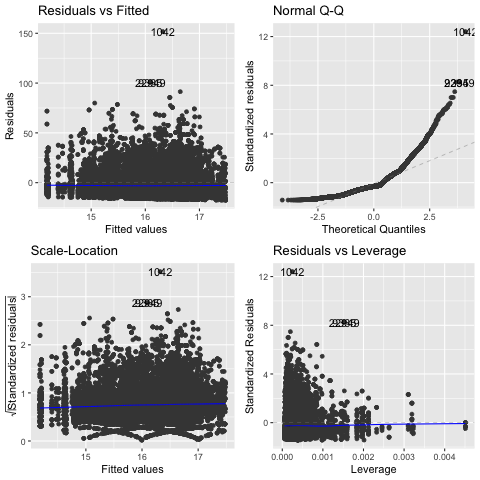

In [23]:
%%R

autoplot(linear_model)

# Logistic Regression :

- Dependent Variable : `binary_grade` [A or not A] 
- Independent Variables : 
    - `total_population`, 
    - `median_household_income`, 
    - `black_perct`, 
    - `asian_perct`, 
    - `no_coll_perct`, 
    - `poverty_rate` 

In [19]:
%%R

rest_model_balanced$binary_grade <- ifelse(rest_model_balanced$grade == 'A', 1, 0)

# Define the model formula
formula <- binary_grade ~ total_population + median_household_income + black_perct + asian_perct + no_coll_perct + poverty_rate

# Fit the logistic regression model
log_model <- glm(formula, data = rest_model_balanced, family = binomial(link = "logit"))

# Print the model summary
summary(log_model)



Call:
glm(formula = formula, family = binomial(link = "logit"), data = rest_model_balanced)

Coefficients:
                          Estimate Std. Error z value Pr(>|z|)    
(Intercept)             -3.183e-03  5.160e-02  -0.062    0.951    
total_population        -3.114e-05  7.284e-06  -4.275 1.91e-05 ***
median_household_income  2.886e-06  4.035e-07   7.152 8.55e-13 ***
black_perct              5.355e-04  7.067e-04   0.758    0.449    
asian_perct             -7.166e-03  1.211e-02  -0.592    0.554    
no_coll_perct            3.822e-03  1.540e-03   2.482    0.013 *  
poverty_rate             1.338e-05  3.154e-05   0.424    0.671    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 32559  on 23707  degrees of freedom
Residual deviance: 32366  on 23701  degrees of freedom
AIC: 32380

Number of Fisher Scoring iterations: 4



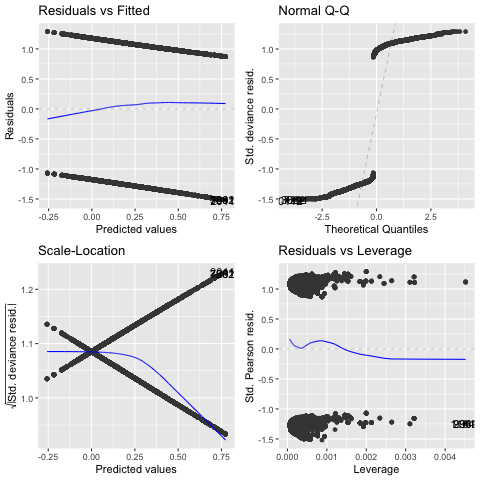

In [30]:
%%R

autoplot(log_model)


Setting levels: control = 0, case = 1
Setting direction: controls < cases


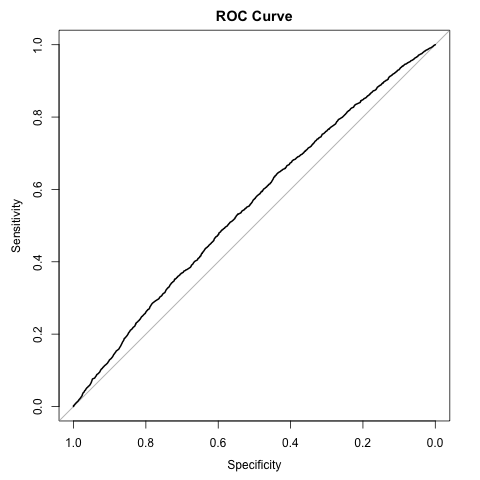

In [29]:
%%R
# Create ROC curve
roc_response <- roc(response = rest_model_balanced$binary_grade, predictor = fitted(model))

# Plot ROC curve
plot(roc_response, main="ROC Curve")

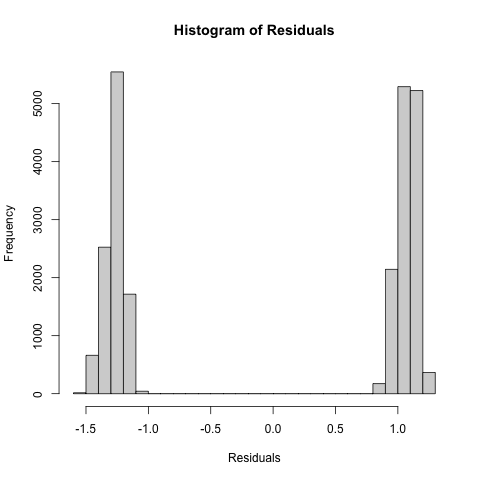

In [27]:
%%R 
hist(residuals, breaks = 30, main = "Histogram of Residuals", xlab = "Residuals")

# GAMs 🎉

In [33]:
%%R

# Fit a Logistic GAM
logistic_gam <- gam(binary_grade ~ s(total_population) + s(median_household_income) + s(black_perct) + s(asian_perct) + s(no_coll_perct) + s(poverty_rate), family=binomial, data=rest_model_balanced)
summary(logistic_gam)



Family: binomial 
Link function: logit 

Formula:
binary_grade ~ s(total_population) + s(median_household_income) + 
    s(black_perct) + s(asian_perct) + s(no_coll_perct) + s(poverty_rate)

Parametric coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  0.23109    0.01317   17.55   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Approximate significance of smooth terms:
                             edf Ref.df Chi.sq p-value    
s(total_population)        7.876  8.674  52.74  <2e-16 ***
s(median_household_income) 7.809  8.596  75.52  <2e-16 ***
s(black_perct)             7.865  8.651  18.30  0.0195 *  
s(asian_perct)             6.257  7.369  14.23  0.0698 .  
s(no_coll_perct)           6.795  7.863  16.09  0.0302 *  
s(poverty_rate)            8.405  8.894  51.29  <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R-sq.(adj) =  0.0127   Deviance explained = 1.06%
UBRE = 0.3626  Scale est. = 1       

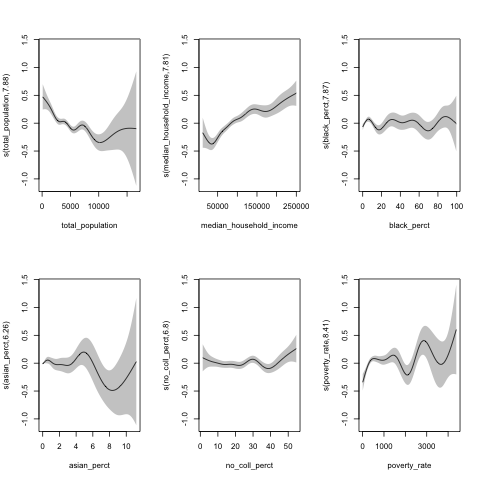

In [35]:
%%R
#partial dependence plots
plot(logistic_gam, pages=1, all.terms=TRUE, se=TRUE, scheme=1)

- total_population: The effect of total population on the response starts negative but plateaus as the population increases, with higher uncertainty at lower population levels.

- median_household_income: There's a strong positive effect on the response as median household income rises initially, but this effect tapers off, indicating diminishing influence at higher income levels.

- black_perct: The percentage of the black population shows a marginally positive effect on the response, although the relationship appears relatively flat, suggesting a weak influence.

- asian_perct: The percentage of the Asian population has a negligible effect on the response, as indicated by the flat line with a narrow confidence interval.

- no_coll_perct: As the percentage of the population without a college degree increases, there's a slight negative impact on the response, implying a potential adverse association.

- poverty_rate: The relationship with the poverty rate is non-linear, where an increase initially leads to a decrease in the response, but levels off at higher rates, indicating no additional impact beyond a certain point.


In [41]:
%%R

confusionMatrix(as.factor(predicted_outcomes), as.factor(actual_outcomes))

Confusion Matrix and Statistics

          Reference
Prediction     0     1
         0  1999  1709
         1  8507 11493
                                          
               Accuracy : 0.5691          
                 95% CI : (0.5628, 0.5754)
    No Information Rate : 0.5569          
    P-Value [Acc > NIR] : 7.581e-05       
                                          
                  Kappa : 0.0651          
                                          
 Mcnemar's Test P-Value : < 2.2e-16       
                                          
            Sensitivity : 0.19027         
            Specificity : 0.87055         
         Pos Pred Value : 0.53910         
         Neg Pred Value : 0.57465         
             Prevalence : 0.44314         
         Detection Rate : 0.08432         
   Detection Prevalence : 0.15640         
      Balanced Accuracy : 0.53041         
                                          
       'Positive' Class : 0               
                  

- While the model's accuracy is not particularly high, and the Cohen's Kappa suggests that there is limited agreement between the model's predictions and the actual outcomes. 
- The model's sensitivity is quite low, meaning it often fails to detect the positive class, whereas it has a high specificity, meaning it is good at identifying the negative class. 
- The model’s ability to predict the positive class (precision) is not very strong, and the balanced accuracy suggests moderate performance on both classes. The significant McNemar's test indicates there might be a bias in the types of errors the model is making.

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2
Registered S3 method overwritten by 'mgcViz':
  method from  
  +.gg   GGally


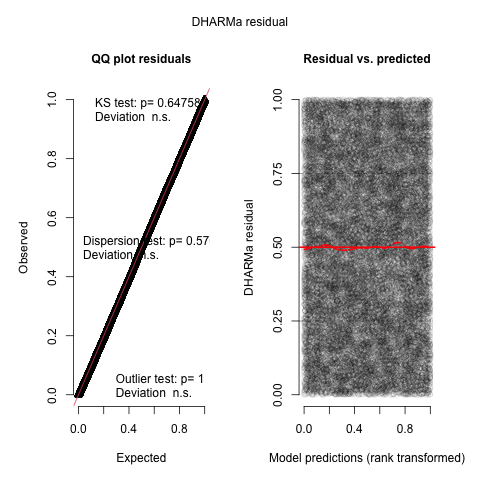

In [42]:
%%R

DHARMa_plot = simulateResiduals(logistic_gam)
plot(DHARMa_plot, smoothScatter = FALSE)